### CSTR Temperature Control

The objective of this case study is to <a href="https://apmonitor.com/pdc/index.php/Main/StirredReactor">automatically maintain a temperature in stirred tank reactor with a highly exothermic reaction</a>. This is an example of a highly nonlinear process that is prone to exponential run-away when the temperature rises too quickly. 

A reactor is used to convert a hazardous chemical A to an acceptable chemical B in waste stream before entering a nearby lake. This particular reactor is dynamically modeled as a Continuously Stirred Tank Reactor (CSTR) with a simplified kinetic mechanism that describes the conversion of reactant A to product B with an irreversible and exothermic reaction. Because the analyzer for product B is not fast enough for real-time control, it is desired to maintain the temperature at a constant set point that maximizes the consumption of A (highest possible temperature).

<img width=50% src="https://apmonitor.com/pdc/uploads/Main/cstr_schematic.png">

### Doublet Test for FOPDT Fit

Perform the necessary open loop tests to determine a first order plus dead time (FOPDT) model that describes the relationship between cooling jacket temperature (MV=$T_c$) and reactor temperature (CV=$T$). Use the file cstr_data.txt to extract the information for the FOPDT model. Obtain an FOPDT model and report the values of the three parameters $K_p$, $\tau_p$, and $\theta_p$.

Below is a step test example in Python. Modify this to start at 300K for the cooling jacket temperature, step up to 303K, down to 297K, and back to 300K in a doublet test.

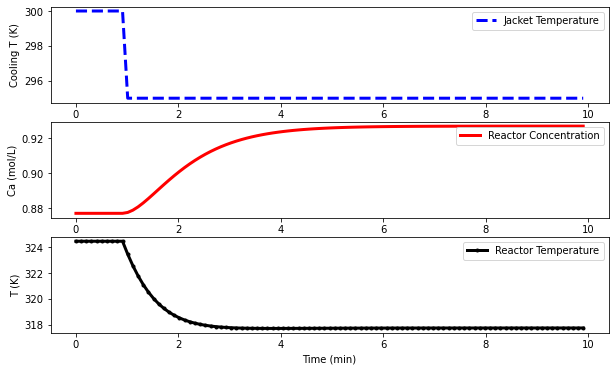

In [1]:
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# animate plots?
animate=True # True / False

# define CSTR model
def cstr(x,t,u,Tf,Caf):
    # Inputs (3):
    # Temperature of cooling jacket (K)
    Tc = u
    # Tf = Feed Temperature (K)
    # Caf = Feed Concentration (mol/m^3)

    # States (2):
    # Concentration of A in CSTR (mol/m^3)
    Ca = x[0]
    # Temperature in CSTR (K)
    T = x[1]

    # Parameters:
    # Volumetric Flowrate (m^3/sec)
    q = 100
    # Volume of CSTR (m^3)
    V = 100
    # Density of A-B Mixture (kg/m^3)
    rho = 1000
    # Heat capacity of A-B Mixture (J/kg-K)
    Cp = 0.239
    # Heat of reaction for A->B (J/mol)
    mdelH = 5e4
    # E - Activation energy in the Arrhenius Equation (J/mol)
    # R - Universal Gas Constant = 8.31451 J/mol-K
    EoverR = 8750
    # Pre-exponential factor (1/sec)
    k0 = 7.2e10
    # U - Overall Heat Transfer Coefficient (W/m^2-K)
    # A - Area - this value is specific for the U calculation (m^2)
    UA = 5e4
    # reaction rate
    rA = k0*np.exp(-EoverR/T)*Ca

    # Calculate concentration derivative
    dCadt = q/V*(Caf - Ca) - rA
    # Calculate temperature derivative
    dTdt = q/V*(Tf - T) \
            + mdelH/(rho*Cp)*rA \
            + UA/V/rho/Cp*(Tc-T)

    # Return xdot:
    xdot = np.zeros(2)
    xdot[0] = dCadt
    xdot[1] = dTdt
    return xdot

# Steady State Initial Conditions for the States
Ca_ss = 0.87725294608097
T_ss = 324.475443431599
x0 = np.empty(2)
x0[0] = Ca_ss
x0[1] = T_ss

# Steady State Initial Condition
u_ss = 300.0
# Feed Temperature (K)
Tf = 350
# Feed Concentration (mol/m^3)
Caf = 1

# Time Interval (min)
t = np.linspace(0,10,100)

# Store results for plotting
Ca = np.ones(len(t)) * Ca_ss
T = np.ones(len(t)) * T_ss
u = np.ones(len(t)) * u_ss

# Step cooling temperature to 295
u[10:] = 295.0

plt.figure(figsize=(10,6))

if animate:
    plt.ion()
    plt.show()

# Simulate CSTR
for i in range(len(t)-1):
    ts = [t[i],t[i+1]]
    y = odeint(cstr,x0,ts,args=(u[i+1],Tf,Caf))
    Ca[i+1] = y[-1][0]
    T[i+1] = y[-1][1]
    x0[0] = Ca[i+1]
    x0[1] = T[i+1]

    # plot results
    if animate:
        display.clear_output(wait=True)
        plt.figure(figsize=(10,6))
        # Plot the results
        plt.subplot(3,1,1)
        plt.plot(t[0:i+1],u[0:i+1],'b--',linewidth=3)
        plt.ylabel('Cooling T (K)')
        plt.legend(['Jacket Temperature'],loc='best')

        plt.subplot(3,1,2)
        plt.plot(t[0:i+1],Ca[0:i+1],'r-',linewidth=3)
        plt.ylabel('Ca (mol/L)')
        plt.legend(['Reactor Concentration'],loc='best')

        plt.subplot(3,1,3)
        plt.plot(t[0:i+1],T[0:i+1],'k.-',linewidth=3)
        plt.ylabel('T (K)')
        plt.xlabel('Time (min)')
        plt.legend(['Reactor Temperature'],loc='best')
        plt.pause(0.01)

# Construct results and save data file
# Column 1 = time
# Column 2 = cooling temperature
# Column 3 = reactor temperature
data = np.vstack((t,u,T)) # vertical stack
data = data.T             # transpose data
np.savetxt('cstr_data.txt',data,delimiter=',',comments="",header='time,u,y')

# Plot the results
if not animate:
    plt.subplot(3,1,1)
    plt.plot(t,u,'b--',linewidth=3)
    plt.ylabel('Cooling T (K)')
    plt.legend(['Jacket Temperature'],loc='best')

    plt.subplot(3,1,2)
    plt.plot(t,Ca,'r-',linewidth=3)
    plt.ylabel('Ca (mol/L)')
    plt.legend(['Reactor Concentration'],loc='best')

    plt.subplot(3,1,3)
    plt.plot(t,T,'k.-',linewidth=3)
    plt.ylabel('T (K)')
    plt.xlabel('Time (min)')
    plt.legend(['Reactor Temperature'],loc='best')

    plt.show()

### Fit FOPDT with Optimization

Fit $K_p$, $\tau_p$, and $\theta_p$ of an FOPDT model using optimization to achieve the best match to the simulated CSTR data. Use optimization to obtain the same parameters in the FOPDT model (see example optimization code) or use <a href="https://pidtuner.com">PIDTuner.com</a>.

Initial SSE Objective: 266.8043600357159
Final SSE Objective: 0.25452066614872043
Kp: 1.3509013814976722
taup: 0.49839757397431994
thetap: 8.766084591394257e-07


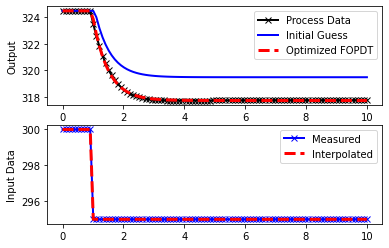

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d

# Import CSV data file
# Column 1 = time (t)
# Column 2 = input (u)
# Column 3 = output (yp)
file = 'cstr_data.txt'
data = pd.read_csv(file)
t = data['time'].values - data['time'].values[0]
u = data['u'].values
yp = data['y'].values
u0 = u[0]
yp0 = yp[0]

# specify number of steps
ns = len(t)
delta_t = t[1]-t[0]
# create linear interpolation of the u data versus time
uf = interp1d(t,u)

# define first-order plus dead-time approximation    
def fopdt(y,t,uf,Km,taum,thetam):
    # arguments
    #  y      = output
    #  t      = time
    #  uf     = input linear function (for time shift)
    #  Km     = model gain
    #  taum   = model time constant
    #  thetam = model time constant
    # time-shift u
    try:
        if (t-thetam) <= 0:
            um = uf(0.0)
        else:
            um = uf(t-thetam)
    except:
        #print('Error with time extrapolation: ' + str(t))
        um = u0
    # calculate derivative
    dydt = (-(y-yp0) + Km * (um-u0))/taum
    return dydt

# simulate FOPDT model with x=[Km,taum,thetam]
def sim_model(x):
    # input arguments
    Km = x[0]
    taum = x[1]
    thetam = x[2]
    # storage for model values
    ym = np.zeros(ns)  # model
    # initial condition
    ym[0] = yp0
    # loop through time steps    
    for i in range(0,ns-1):
        ts = [t[i],t[i+1]]
        y1 = odeint(fopdt,ym[i],ts,args=(uf,Km,taum,thetam))
        ym[i+1] = y1[-1]
    return ym

# define objective
def objective(x):
    # simulate model
    ym = sim_model(x)
    # calculate objective
    obj = 0.0
    for i in range(len(ym)):
        obj = obj + (ym[i]-yp[i])**2    
    # return result
    return obj

# initial guesses
x0 = np.zeros(3)
x0[0] = 1.0 # Km
x0[1] = 0.5 # taum
x0[2] = 0.1 # thetam

# show initial objective
print('Initial SSE Objective: ' + str(objective(x0)))

# optimize Km, taum, thetam
#solution = minimize(objective,x0)

# Another way to solve: with bounds on variables
bnds = ((0.5, 3.0), (0.2, 2.0), (0.0, 0.2))
solution = minimize(objective,x0,bounds=bnds,method='SLSQP')
x = solution.x

# show final objective
print('Final SSE Objective: ' + str(objective(x)))

print('Kp: ' + str(x[0]))
print('taup: ' + str(x[1]))
print('thetap: ' + str(x[2]))

# calculate model with updated parameters
ym1 = sim_model(x0)
ym2 = sim_model(x)
# plot results
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,yp,'kx-',linewidth=2,label='Process Data')
plt.plot(t,ym1,'b-',linewidth=2,label='Initial Guess')
plt.plot(t,ym2,'r--',linewidth=3,label='Optimized FOPDT')
plt.ylabel('Output')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(t,u,'bx-',linewidth=2)
plt.plot(t,uf(t),'r--',linewidth=3)
plt.legend(['Measured','Interpolated'],loc='best')
plt.ylabel('Input Data')
plt.show()

### Design PI or PID Controller

Use the $K_p$, $\tau_p$, and $\theta_p$ from the FOPDT model in the Internal Model Control (IMC) PI tuning correlation or PID tuning correlation to obtain starting values of $K_c$, $\tau_I$, and $\tau_D$ for a <a href="https://apmonitor.com/pdc/index.php/Main/ProportionalIntegralControl">PI controller</a> or <a href="https://apmonitor.com/pdc/index.php/Main/ProportionalIntegralDerivative">PID controller</a>. Use an aggressive value for the closed loop time constant, $\tau_c=0.1 \tau_p$.

### Implement PI or PID Controller

Using $K_c$, $\tau_I$, and $\tau_D$ from the IMC tuning correlation, implement a PID controller with anti-reset windup. Test the set point tracking capability of this controller by plotting the response of the process to steps in set point of the reactor temperature (not cooling jacket temperature) from 300K up to 320K and then down to 280K. Limit the cooling jacket temperature between 250K and 350K. Comment on how the nonlinear behavior of this process impacts your observed set point response performance.

### Tune PI or PID Controller

Improve the tuning by adjusting $K_c$, $\tau_I$, and $\tau_D$ by trial and error until the controller displays a 10% to 15% overshoot in response to a reactor temperature set point step from 300K to 320K. Plot this set point step response.

### Challenge: Lowest Concentration

Step up the set point to achieve a maximum temperature in the reactor without exceeding the maximum allowable temperature of 400K (don’t cause a reactor run-away). What is the lowest concentration that can be achieved without exceeding the maximum allowable temperature? This is a very difficult problem due to the potential for reactor temperature run-away. Derivative action may be necessary to achieve the best performance.

### Sample PID Code

The following code is an implementation of a PID controller but is unable to keep the reactor temperature below the upper limit of 400K. 

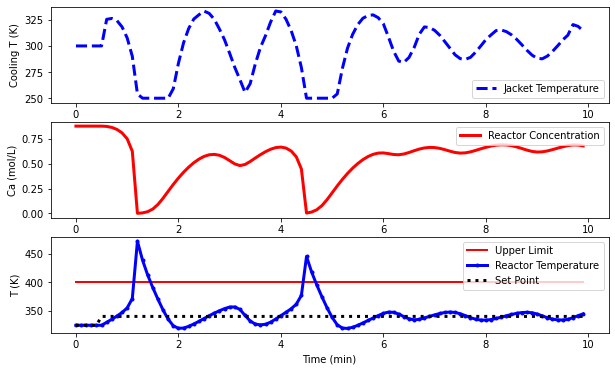

In [5]:
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from simple_pid import PID  # pip install simple_pid
import time

make_gif = True
try:
    import imageio  # required to make gif animation
except:
    print('install imageio with "pip install imageio" to make gif')
    make_gif=False
if make_gif:
    try:
        import os
        images = []
        os.mkdir('./frames')
    except:
        pass

# define CSTR model
def cstr(x,t,u,Tf,Caf):
    # Inputs (3):
    # Temperature of cooling jacket (K)
    Tc = u
    # Tf = Feed Temperature (K)
    # Caf = Feed Concentration (mol/m^3)

    # States (2):
    # Concentration of A in CSTR (mol/m^3)
    Ca = x[0]
    # Temperature in CSTR (K)
    T = x[1]

    # Parameters:
    # Volumetric Flowrate (m^3/sec)
    q = 100
    # Volume of CSTR (m^3)
    V = 100
    # Density of A-B Mixture (kg/m^3)
    rho = 1000
    # Heat capacity of A-B Mixture (J/kg-K)
    Cp = 0.239
    # Heat of reaction for A->B (J/mol)
    mdelH = 5e4
    # E - Activation energy in the Arrhenius Equation (J/mol)
    # R - Universal Gas Constant = 8.31451 J/mol-K
    EoverR = 8750
    # Pre-exponential factor (1/sec)
    k0 = 7.2e10
    # U - Overall Heat Transfer Coefficient (W/m^2-K)
    # A - Area - this value is specific for the U calculation (m^2)
    UA = 5e4
    # reaction rate
    rA = k0*np.exp(-EoverR/T)*Ca

    # Calculate concentration derivative
    dCadt = q/V*(Caf - Ca) - rA
    # Calculate temperature derivative
    dTdt = q/V*(Tf - T) \
            + mdelH/(rho*Cp)*rA \
            + UA/V/rho/Cp*(Tc-T)

    # Return xdot:
    xdot = np.zeros(2)
    xdot[0] = dCadt
    xdot[1] = dTdt
    return xdot

# Steady State Initial Conditions for the States
Ca_ss = 0.87725294608097
T_ss = 324.475443431599
x0 = np.empty(2)
x0[0] = Ca_ss
x0[1] = T_ss

# Steady State Initial Condition
u_ss = 300.0
# Feed Temperature (K)
Tf = 350
# Feed Concentration (mol/m^3)
Caf = 1

# Time Interval (min)
t = np.linspace(0,10,101)

# Store results for plotting
Ca = np.ones(len(t)) * Ca_ss
T = np.ones(len(t)) * T_ss
u = np.ones(len(t)) * u_ss

# setpoint
sp = np.ones(101) * T_ss
sp[5:] = 340.0
u_bias = u_ss

# create PID controller
# op = op_bias + Kc * e + Ki * ei + Kd * ed
#      with ei = error integral
#      with ed = error derivative
Kc = 1.0      # Controller gain
Ki = 1.0      # Controller integral parameter
Kd = 0.0      # Controller derivative parameter
pid = PID(Kc,Ki,Kd)
# lower and upper controller output limits
oplo = 250.0
ophi = 350.0
pid.output_limits = (oplo-u_bias,ophi-u_bias)
# PID sample time
pid.sample_time = 0.1

plt.figure(figsize=(10,6))  
plt.ion()

# timing functions
tm = np.zeros(101)
sleep_max = 0.101
start_time = time.time()
prev_time = start_time

# Simulate CSTR
for i in range(len(t)-1):
    # PID control
    pid.setpoint=sp[i]
    u[i+1] = pid(T[i]) + u_bias

    ts = [t[i],t[i+1]]
    y = odeint(cstr,x0,ts,args=(u[i+1],Tf,Caf))
    Ca[i+1] = y[-1][0]
    T[i+1] = y[-1][1]
    x0[0] = Ca[i+1]
    x0[1] = T[i+1]

    # plot results
    display.clear_output(wait=True)
    plt.figure(figsize=(10,6))  
    # Plot the results
    plt.subplot(3,1,1)
    plt.plot(t[0:i+1],u[0:i+1],'b--',linewidth=3)
    plt.ylabel('Cooling T (K)')
    plt.legend(['Jacket Temperature'],loc='best')

    plt.subplot(3,1,2)
    plt.plot(t[0:i+1],Ca[0:i+1],'r-',linewidth=3)
    plt.ylabel('Ca (mol/L)')
    plt.legend(['Reactor Concentration'],loc='best')

    plt.subplot(3,1,3)
    plt.plot([t[0],t[i]],[400.0,400.0],'r-',linewidth=2)
    plt.plot(t[0:i+1],T[0:i+1],'b.-',linewidth=3)
    plt.plot(t[0:i+1],sp[0:i+1],'k:',linewidth=3)
    plt.ylabel('T (K)')
    plt.xlabel('Time (min)')
    plt.legend(['Upper Limit','Reactor Temperature','Set Point'],loc='best')

    if make_gif:
        filename='./frames/frame_'+str(1000+i)+'.png'
        plt.savefig(filename)
        images.append(imageio.imread(filename))
    plt.pause(0.001)

    # Sleep time
    sleep = sleep_max - (time.time() - prev_time)
    if sleep>=0.001:
        time.sleep(sleep-0.001)
    else:
        time.sleep(0.001)

    # Record time and change in time
    ct = time.time()
    dt = ct - prev_time
    prev_time = ct
    tm[i+1] = ct - start_time

# Construct results and save data file
# Column 1 = time
# Column 2 = cooling temperature
# Column 3 = reactor temperature
data = np.vstack((t,u,T)) # vertical stack
data = data.T             # transpose data
np.savetxt('cstr_pid_results.txt',data,delimiter=',',comments="",header='time,u,y')

# create animated GIF
if make_gif:
    imageio.mimsave('animate.gif', images)
    #imageio.mimsave('animate.mp4', images)  # requires ffmpeg